In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, brentq
import math
from scipy.constants import N_A

In [66]:
# Define constants
Target_cell_number = 2e5
well_size = 125e-6
t_end = 60*60*5
t = np.geomspace(1e-10, t_end, 500)
t_span = [1e-10, t_end]
z0 = [0, 0]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
sigma = well_size*N_A/Target_cell_number

In [67]:
# Define EC50 finder

def EC50_finder(array, A0s):
    half_max = 0.5*np.max(array) 
    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return A0s[indicies[0]]

In [68]:
def mono_valent_steady_state(Ainit, k1, koff, rtot):
    k1 = k1/sigma
    Atot = sigma*Ainit
    a = 1
    b = -((koff/k1) + rtot + Atot)
    c = rtot*Atot

    st = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

    return st

def A2_steady_state(x, k2, koff, rtot):
    K2 = k2/koff
    rtot = rtot*K2
    express = x*(rtot -x)/(2*(1+x))

    return express


def A1_steady_state(x, Ainit, kon, koff, k2, rtot):
    k1 = kon/sigma
    Atot = sigma*Ainit
    K1 = k1/koff
    K2 = k2/koff
    Atot = Atot*K2
    rtot = rtot*K2
    K21 = K2/K1

    f0 = 2*rtot*Atot/(1-K21)
    f1 = 2*(rtot-1)*Atot/(1-K21) + 1 - (((rtot + 1)**2)/(1-K21))
    f2 = 2*(1- (Atot/(1-K21)))
    f3 = 1 
    express = (f3*(x**3) + f2*(x**2) + f1*x + f0)
    return express


In [69]:
A0s = np.geomspace(1e-13, 5e-5, 250)
kon_powers = np.linspace(5, 3, 350)
koff_powers = np.linspace(-5, -1, 350)
rtots = np.linspace(3, 6, 350)
kons = np.flip(10**kon_powers)
koffs = np.flip(10**koff_powers)
rtots = 10**rtots
D = 1e-13
k2 = D/tumour_cell_surface_area
mono_Ec50s = np.zeros_like(kon_powers)
biv_Ec50s = np.zeros_like(kon_powers)
Y = np.zeros((len(rtots), len(rtots)))
Y1 = np.zeros((len(rtots), len(rtots)))

for k, rtot in enumerate(rtots):
    for i, kon in enumerate(kons):
        kon = 1e5
        bivalent = np.zeros_like(A0s)
        bivalent1 = np.zeros_like(A0s)
        koff = koffs[i]
        for j, Ainit in enumerate(A0s):

            # simulate bivalent binding
            K2 = k2/koff
            A1_st = (brentq(A1_steady_state, 0, rtot*K2, args=(Ainit, kon, koff, k2, rtot)))/K2
            A2_st = (A2_steady_state(A1_st*K2, k2, koff, rtot))/K2
            
            Ab = A1_st + A2_st # bound antibody
            Ab1 = A1_st + 2*A2_st # receptor occupancy
            bivalent[j] = Ab
            bivalent1[j] = Ab1
        
        # simulate monovalent binding and calculate EC50s
        mono_ec50 = EC50_finder(mono_valent_steady_state(A0s, kon, koff, rtot), A0s)
        biv_Ec50 = EC50_finder(bivalent, A0s) 
        biv_Ec501 = EC50_finder(bivalent1, A0s)
        delta_Ec50 = np.log10(mono_ec50) - np.log10(biv_Ec50)
        delta_Ec501 = np.log10(mono_ec50) - np.log10(biv_Ec501)
        if mono_ec50 < biv_Ec501:
            print(mono_ec50, biv_Ec501)
        Y[i, k] = delta_Ec50
        Y1[i, k] = delta_Ec501



0


/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_20626/464722962.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[i, k] = delta_Ec50
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_20626/464722962.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y1[i, k] = delta_Ec501


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


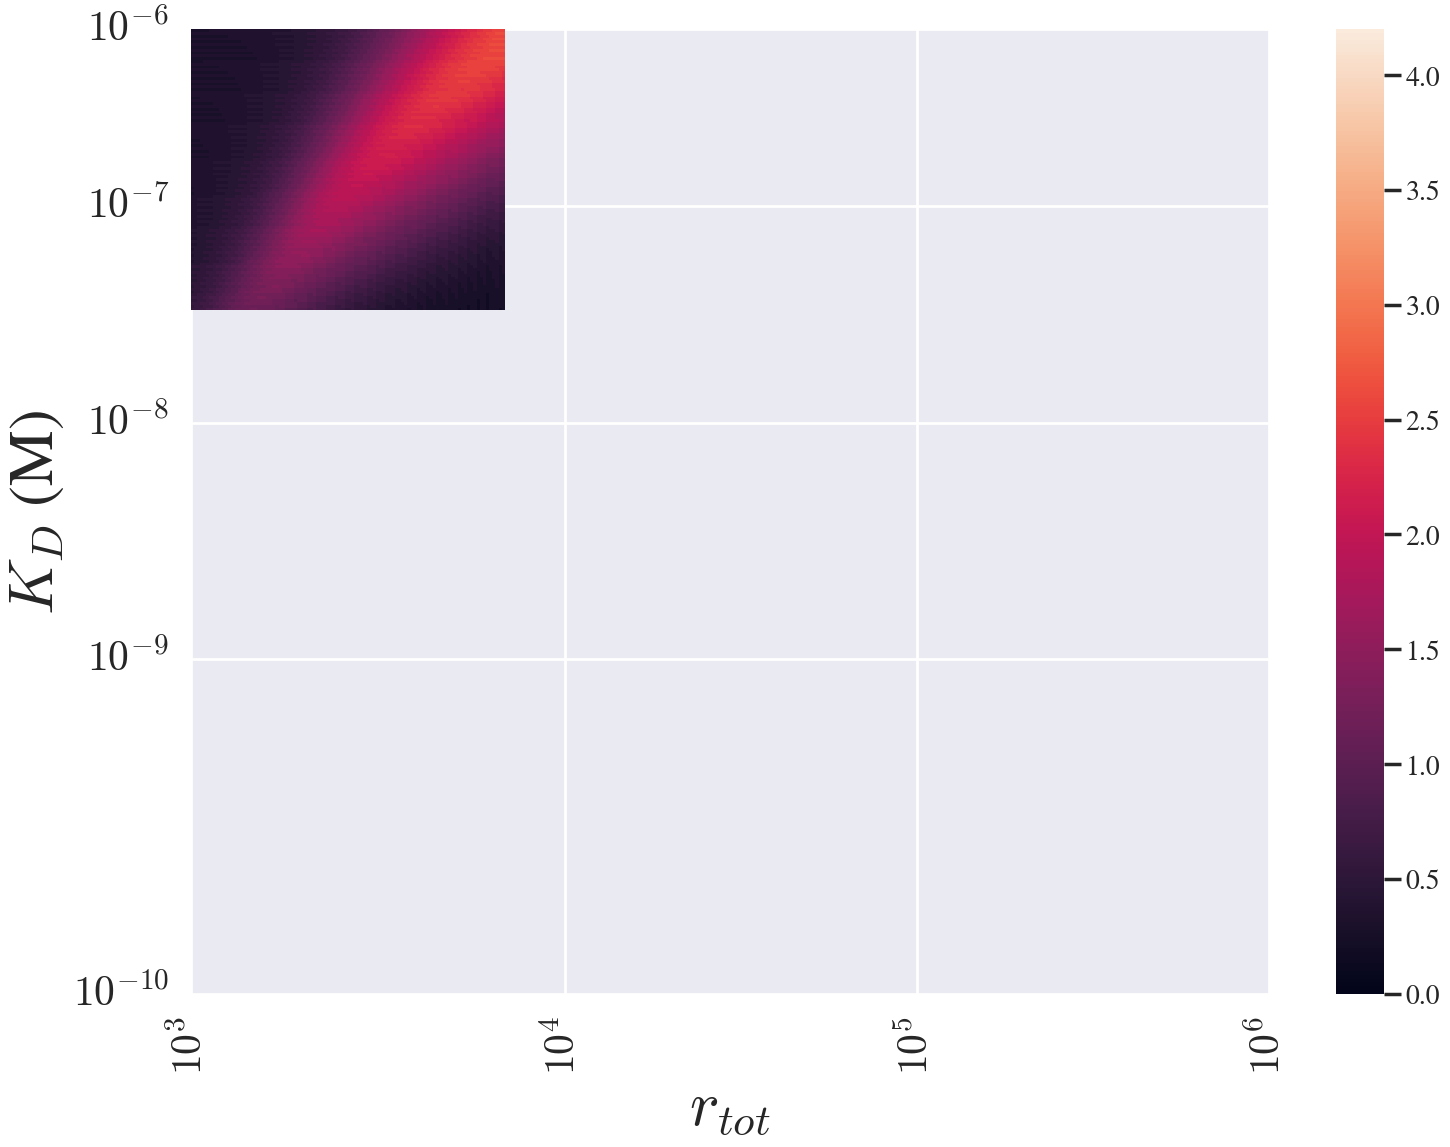

In [70]:
sns.set_theme()
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE =10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=BIGGER_SIZE)
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(16, 12))
line = sns.heatmap(Y, xticklabels=True, yticklabels=True, ax=ax, vmin=0, vmax=4.2) 
ax.set_yticks([0, 9*7, 20*7, 32*7, 49*7])
ax.set_xticks([0, 17*7, 33*7, 49*7])
ax.set_yticklabels(np.flip([r'$10^{-10}$', r'$10^{-9}$',r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$']), fontsize=30)
ax.set_xticklabels([r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$'], fontsize=30)
ax.set_xlabel(r'$r_{tot}$', fontsize=45)
ax.set_ylabel(r'$K_D$ (M)', fontsize=45)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()